In this notebook, I will use what we already created in our initial midterm notebooks and improve upon it so as to make a better product for our final. To start, we're going to bring back in our original trees dataframe as well as our three Census variables.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from sklearn import linear_model
oaktrees=gpd.read_file('https://opendata.arcgis.com/datasets/385456a220174ef1854738b4029df3fd_0.geojson')

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
oakincome=gpd.read_file('oakdata.geojson')
oakrace=gpd.read_file('oakrace.geojson')
oakeduc=gpd.read_file('oakeduc.geojson')

And just quickly paste over our data cleaning...

In [4]:
oakincome.columns = ['geoid',
                   'name',
                   'Median Income',
                   'Margin Of Error',
                   'geometry']

In [5]:
oakincome=oakincome.drop([337])

In [6]:
oakrace_columnstokeep=['geoid',
                       'name',
                       'B03002001',
                       'B03002002',
                       'B03002003',
                       'B03002004',
                       'B03002005',
                       'B03002006',
                       'B03002007',
                       'B03002008',
                       'B03002009',
                       'B03002012',
                       'geometry']
oakrace=oakrace[oakrace_columnstokeep]

In [7]:
oakrace=oakrace.drop([337])

In [8]:
oakrace.columns= ['geoid', 'name', 
                   'Total', 
                   'Not Hispanic or Latino', 
                   'White alone', 
                   'Black or African American alone', 
                   'American Indian and Alaska Native alone',
                   'Asian alone',
                   'Native Hawaiian and Other Pacific Islander alone',
                   'Some other race alone',
                   'Two or more races',
                   'Hispanic or Latino',
                   'geometry']
oakrace['Percent Non Hispanic'] = oakrace['Not Hispanic or Latino']/oakrace['Total']*100
oakrace['Percent White'] = oakrace['White alone']/oakrace['Total']*100
oakrace['Percent Black'] = oakrace['Black or African American alone']/oakrace['Total']*100
oakrace['Percent Native American'] = oakrace['American Indian and Alaska Native alone']/oakrace['Total']*100
oakrace['Percent Asian'] = oakrace['Asian alone']/oakrace['Total']*100
oakrace['Percent Hawaiian/PI'] = oakrace['Native Hawaiian and Other Pacific Islander alone']/oakrace['Total']*100
oakrace['Percent other race'] = oakrace['Some other race alone']/oakrace['Total']*100
oakrace['Percent two or more races'] = oakrace['Two or more races']/oakrace['Total']*100
oakrace['Percent Hispanic/Latino'] = oakrace['Hispanic or Latino']/oakrace['Total']*100

In [9]:
oakeduc['High school or less']=oakeduc['B15003002']+oakeduc['B15003003']+oakeduc['B15003004']+oakeduc['B15003005']+oakeduc['B15003006']+oakeduc['B15003007']+oakeduc['B15003008']+oakeduc['B15003009']+oakeduc['B15003010']+oakeduc['B15003011']+oakeduc['B15003012']+oakeduc['B15003013']+oakeduc['B15003014']+oakeduc['B15003015']+oakeduc['B15003016']+oakeduc['B15003017']
oakeduc['Some college']=oakeduc['B15003019']+oakeduc['B15003020']

In [10]:
oakeduccol=['geoid',
            'name',
            'B15003001',
            'B15003018',
            'B15003021',
            'B15003022',
            'B15003023',
            'B15003024',
            'B15003025',
            'geometry',
            'High school or less',
            'Some college']
oakeduc=oakeduc[oakeduccol]

In [11]:
oakeduc.columns=['geoid',
                 'name',
                 'Total',
                 'GED',
                 'Associates',
                 'Bachelor',
                 'Master',
                 'Professional school',
                 'Doctorate',
                 'geometry',
                 'High school or less',
                 'Some college']

In [12]:
oakeduc=oakeduc.drop([337])

In [13]:
oakeduc['Percent GED'] = oakeduc['GED']/oakeduc['Total']*100
oakeduc['Percent Associates'] = oakeduc['Associates']/oakeduc['Total']*100
oakeduc['Percent Bachelor'] = oakeduc['Bachelor']/oakeduc['Total']*100
oakeduc['Percent Master'] = oakeduc['Master']/oakeduc['Total']*100
oakeduc['Percent Professional school'] = oakeduc['Professional school']/oakeduc['Total']*100
oakeduc['Percent Doctorate'] = oakeduc['Doctorate']/oakeduc['Total']*100
oakeduc['Percent High school or less'] = oakeduc['High school or less']/oakeduc['Total']*100
oakeduc['Percent Some college'] = oakeduc['Some college']/oakeduc['Total']*100

In [14]:
oakeduc['Percent Higher Ed']=oakeduc['Percent Bachelor']+oakeduc['Percent Master']+oakeduc['Percent Doctorate']

Finally, we're going to complete our merge of the trees datasets with the Census variables.

In [15]:
oakmerge=gpd.sjoin(oakincome,oaktrees)
oaktrees_income=oakmerge.value_counts('geoid').reset_index(name='trees in census block')
oak_trees_income=oakincome.merge(oaktrees_income,how='left',on='geoid')

In [16]:
oakmerge2=gpd.sjoin(oakrace,oaktrees)
oaktrees_race=oakmerge2.value_counts('geoid').reset_index(name='trees in census block')
oak_trees_race=oakrace.merge(oaktrees_race,how='left',on='geoid')

In [17]:
oakmerge3=gpd.sjoin(oakeduc,oaktrees)
oaktrees_educ=oakmerge3.value_counts('geoid').reset_index(name='trees in census block')
oak_trees_educ=oakeduc.merge(oaktrees_educ,how='left',on='geoid')

Now our various dataframes are exactly where they were at the midterm stage. However, after running our initial analysis, we realized that the data was telling an incomplete story because of the influence of census blocks in the hills, which have very few to no street trees and generally high incomes. Thankfully, by removing just the census blocks with a null value for "trees in census block," many hills blocks are eliminated. We'll start there, and then remove the handful of census blocks with fewer than 100 people or fewer than 10 street trees.

In [18]:
almostcleanoakincome=oak_trees_income.dropna(subset=['trees in census block'])

In [19]:
yuckyoakincome=almostcleanoakincome[(almostcleanoakincome['trees in census block'] <= 10)].index
cleanoakincome=almostcleanoakincome.drop(yuckyoakincome)

In [20]:
oak1=oak_trees_race.dropna(subset=['trees in census block'])

In [21]:
badoakrace=oak1[(oak1['Total'] <= 100)].index
almostcleanoakrace=oak1.drop(badoakrace)

In [22]:
yuckyoakrace=almostcleanoakrace[(almostcleanoakrace['trees in census block'] <= 10)].index
cleanoakrace=almostcleanoakrace.drop(yuckyoakrace)

In [23]:
oaked=oak_trees_educ.dropna(subset=['trees in census block'])

In [24]:
badoakeduc=oaked[(oaked['Total'] <= 100)].index
almostcleanoakeduc=oaked.drop(badoakeduc)

In [25]:
yuckyoakeduc=almostcleanoakeduc[(almostcleanoakeduc['trees in census block'] <= 10)].index
cleanoakeduc=almostcleanoakeduc.drop(yuckyoakeduc)

Fantastic! After some wrangling, each of the dataframes are even cleaner than they were on the midterm, which means it's time to make some sweet basemaps. Below, I will convert each Census variable dataframe into the relevant coordinate projection, and then I will lay my data down on a basemap of the city of Oakland, California.

In [26]:
oakincome_mercator = cleanoakincome.to_crs(epsg=3857)

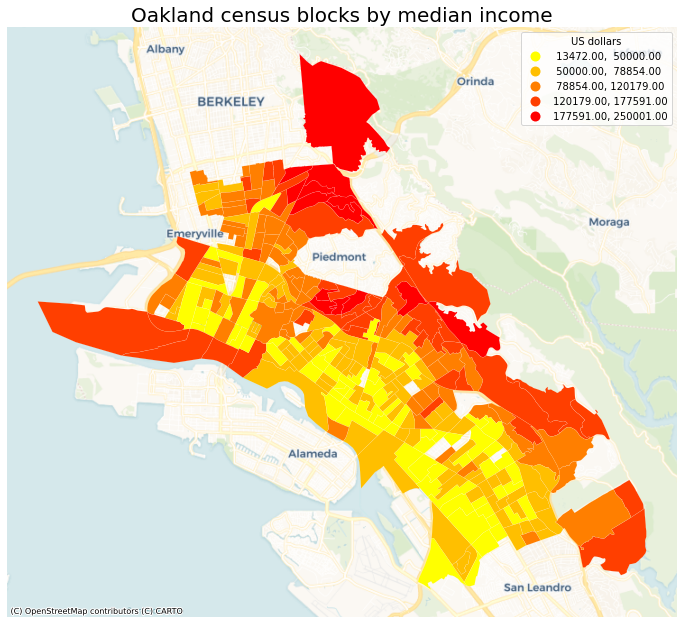

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))
oakincome_mercator.plot(column='Median Income', 
            cmap='autumn_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True),
           )
ax.axis("off")
ax.set_title("Oakland census blocks by median income",fontsize=20)
ax.get_legend().set_title("US dollars")
ctx.add_basemap(ax, crs=oakincome_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('censusblocks.png')

In [28]:
oakincome_mercator.head()
oakincome_mercator['area']=oakincome_mercator.area/(10**6)

In [29]:
oakincome_mercator.sort_values(by='trees in census block',inplace=True,ascending=False)

In [30]:
oakincome_mercator['trees per sq km']=oakincome_mercator['trees in census block']/oakincome_mercator['area']

In [31]:
oakincome_mercator.head(10)

,geoid,name,Median Income,Margin Of Error,geometry,trees in census block,area,trees per sq km
6,15000US060014003004,"Block Group 4, Alameda, CA",160294.0,21088.0,"MULTIPOLYGON (((-13609706.543 4556607.015, -13...",533.0,0.447161,1191.965545
1,15000US060014002001,"Block Group 1, Alameda, CA",237500.0,23842.0,"MULTIPOLYGON (((-13609373.698 4557703.289, -13...",470.0,0.462790,1015.580408
7,15000US060014004001,"Block Group 1, Alameda, CA",135278.0,15423.0,"MULTIPOLYGON (((-13609617.487 4558722.419, -13...",463.0,0.428709,1079.986302
104,15000US060014043002,"Block Group 2, Alameda, CA",194856.0,39598.0,"MULTIPOLYGON (((-13608599.582 4557043.988, -13...",457.0,0.551978,827.931393
8,15000US060014004002,"Block Group 2, Alameda, CA",80875.0,40335.0,"MULTIPOLYGON (((-13610124.214 4557076.550, -13...",445.0,0.397854,1118.501781
10,15000US060014005001,"Block Group 1, Alameda, CA",109833.0,18546.0,"MULTIPOLYGON (((-13610603.110 4558540.691, -13...",436.0,0.582706,748.233079
332,15000US060014105001,"Block Group 1, Alameda, CA",31151.0,8384.0,"MULTIPOLYGON (((-13613661.502 4551957.909, -13...",430.0,1.162647,369.845858
4,15000US060014003002,"Block Group 2, Alameda, CA",101736.0,36064.0,"MULTIPOLYGON (((-13610177.536 4556545.981, -13...",405.0,0.432570,936.265330
125,15000US060014049004,"Block Group 4, Alameda, CA",152143.0,13858.0,"MULTIPOLYGON (((-13606670.749 4551620.334, -13...",379.0,0.494440,766.523540
48,15000US060014017001,"Block Group 1, Alameda, CA",139545.0,8873.0,"MULTIPOLYGON (((-13613747.997 4553956.530, -13...",351.0,1.393348,251.911268


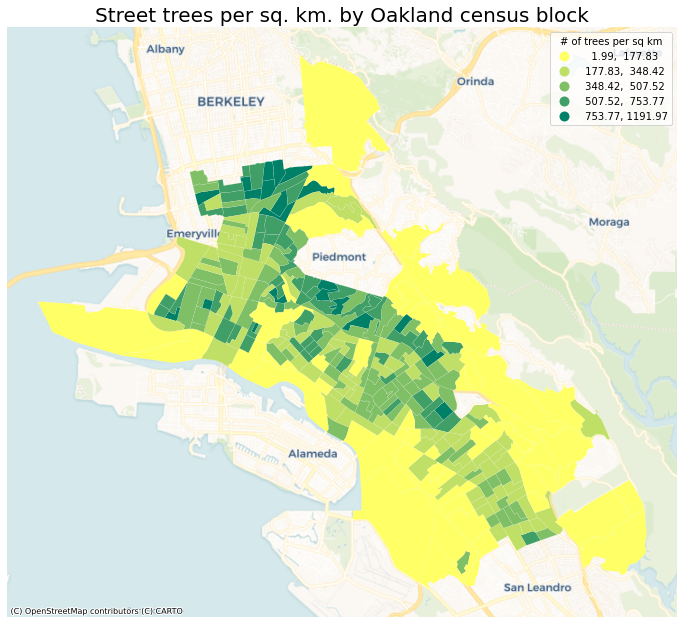

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))
oakincome_mercator.plot(column='trees per sq km', 
            cmap='summer_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True)
           )
ax.axis("off")
ax.set_title("Street trees per sq. km. by Oakland census block",fontsize=20)
ax.get_legend().set_title("# of trees per sq km")
ctx.add_basemap(ax, crs=oakincome_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('oaktrees.png')

In [33]:
oakeduc_mercator = cleanoakeduc.to_crs(epsg=3857)

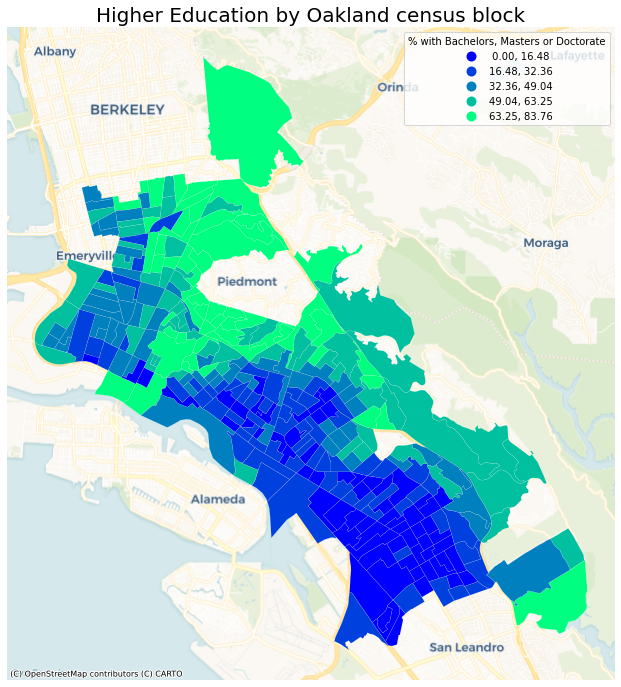

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
oakeduc_mercator.plot(column='Percent Higher Ed', 
            cmap='winter', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True)
           )
ax.axis("off")
ax.set_title("Higher Education by Oakland census block",fontsize=20)
ax.get_legend().set_title("% with Bachelors, Masters or Doctorate")
ctx.add_basemap(ax, crs=oakeduc_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('highered.png')

In [35]:
oakrace_mercator = cleanoakrace.to_crs(epsg=3857)

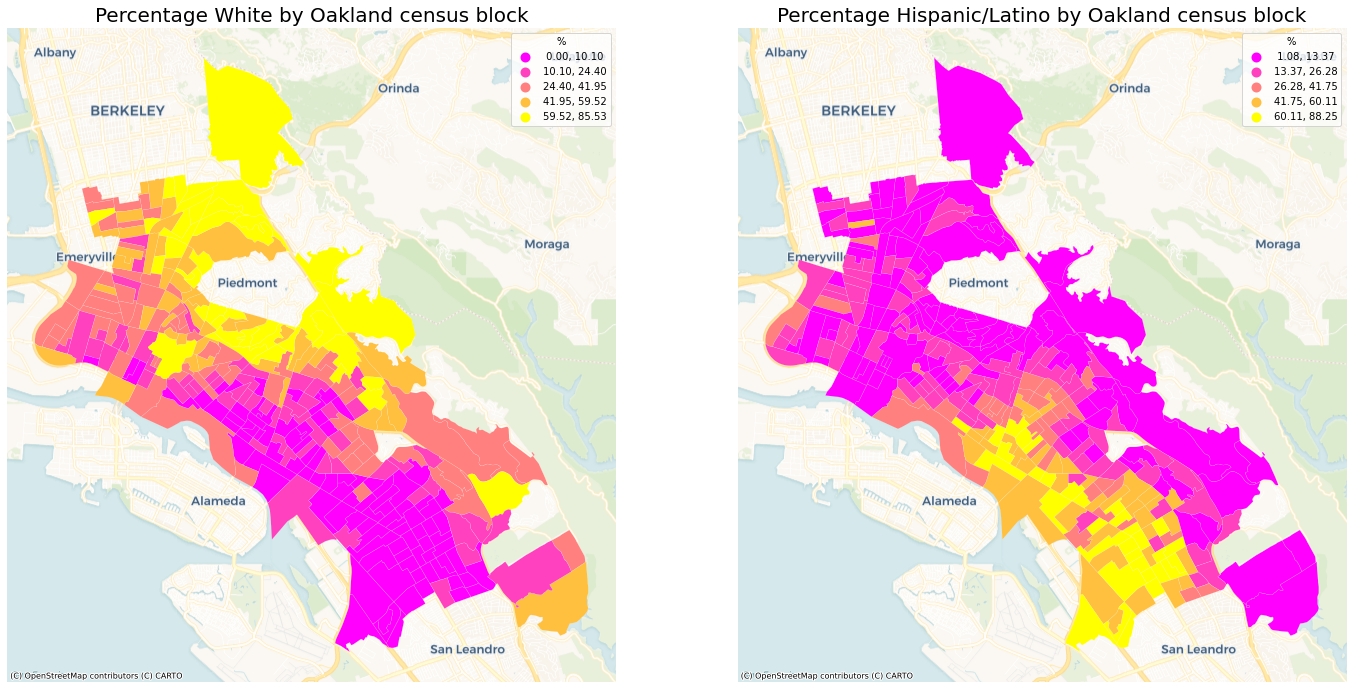

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=True, sharey=True)
ax1, ax2 = axs

oakrace_mercator.plot(column='Percent White', 
            cmap='spring', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax1,
            legend=(True)
           )
ax1.axis("off")
ax1.set_title("Percentage White by Oakland census block",fontsize=20)
ax1.get_legend().set_title("%")
ctx.add_basemap(ax1, crs=oakrace_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

oakrace_mercator.plot(column='Percent Hispanic/Latino', 
            cmap='spring', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax2,
            legend=(True)
           )
ax2.axis("off")
ax2.set_title("Percentage Hispanic/Latino by Oakland census block",fontsize=20)
ax2.get_legend().set_title("%")
ctx.add_basemap(ax2, crs=oakrace_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('oakrace.png')

In [37]:
oakincome_corr=cleanoakincome.dropna(subset=['Median Income'])

In [38]:
a=oakincome_corr['trees in census block']
e=oakincome_corr['Median Income']
c=np.array(oakincome_corr['trees in census block'])
d=np.array(oakincome_corr['Median Income'])
m, b = np.polyfit(c, d, 1)

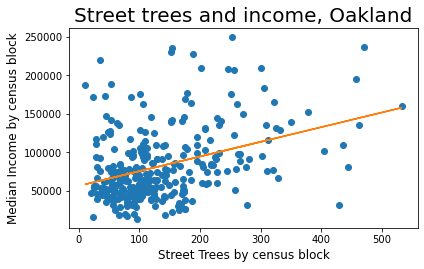

In [39]:
plt.plot(a,e,'o')
plt.plot(c, m*c + b)
plt.title(label="Street trees and income, Oakland",
          fontsize=20,
          color="black",)
plt.xlabel('Street Trees by census block', fontsize=12)
plt.ylabel('Median Income by census block', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('scatterincome.png')

In [40]:
np.corrcoef(oakincome_corr['Median Income'], oakincome_corr['trees in census block'])

array([[1.        , 0.37275766],
       [0.37275766, 1.        ]])

In [41]:
oakeduc_corr=cleanoakeduc.dropna(subset=['Percent Higher Ed'])

In [42]:
f=oakeduc_corr['trees in census block']
g=oakeduc_corr['Percent Higher Ed']
h=np.array(oakeduc_corr['trees in census block'])
i=np.array(oakeduc_corr['Percent Higher Ed'])
mm, bb = np.polyfit(h, i, 1)

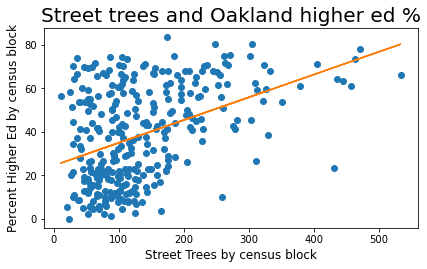

In [43]:
plt.plot(f,g,'o')
plt.plot(h, mm*h + bb)
plt.title(label="Street trees and Oakland higher ed %",
          fontsize=20,
          color="black",)
plt.xlabel('Street Trees by census block', fontsize=12)
plt.ylabel('Percent Higher Ed by census block', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('scattered.png')

In [44]:
np.corrcoef(oakeduc_corr['Percent Higher Ed'], oakeduc_corr['trees in census block'])

array([[1.        , 0.42581632],
       [0.42581632, 1.        ]])

In [45]:
oakrace_corr=cleanoakrace.dropna(subset=['Percent White'])

In [46]:
j=oakrace_corr['trees in census block']
k=oakrace_corr['Percent White']
l=np.array(oakrace_corr['trees in census block'])
n=np.array(oakrace_corr['Percent White'])
mmm, bbb = np.polyfit(l, n, 1)

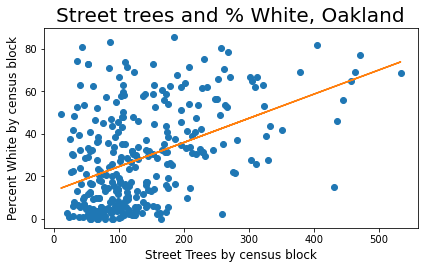

In [47]:
plt.plot(j,k,'o')
plt.plot(l, mmm*l + bbb)
plt.title(label="Street trees and % White, Oakland",
          fontsize=20,
          color="black",)
plt.xlabel('Street Trees by census block', fontsize=12)
plt.ylabel('Percent White by census block', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('scatterrace.png')

In [48]:
np.corrcoef(oakrace_corr['Percent White'], oakrace_corr['trees in census block'])

array([[1.        , 0.44593007],
       [0.44593007, 1.        ]])

In [49]:
oak_income_race = oak_trees_income.merge(oak_trees_race, how="left", on='geoid')

In [50]:
oak_income_race_educ = oak_income_race.merge(oak_trees_educ, how="left", on='geoid')

In [51]:
coltokeep=['geoid','Median Income','Percent White','Percent Higher Ed','trees in census block','geometry']

In [52]:
oak_income_race_educ=oak_income_race_educ[coltokeep]

In [53]:
oakmodel=oak_income_race_educ.dropna(subset=['trees in census block'])

In [54]:
oak_model=oakmodel.dropna(subset=['Median Income'])

In [55]:
reg = linear_model.LinearRegression()

In [56]:
reg.fit(oak_model[['Median Income','Percent Higher Ed','Percent White']],oak_model['trees in census block'])

LinearRegression()

In [57]:
reg.coef_

array([1.19434167e-04, 6.24180219e-01, 9.59563840e-01])

In [58]:
reg.predict([[160294,68.58,66.17]])

array([197.81283074])

In [59]:
reg.intercept_

72.36763172019728